# Analyse Datensatz 2

Hier wird an Datensatz 2 ein zweites Beispiel dargestellt, wie sich ein solcher Datensatz analysieren lässt.

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

class Dataset:

    def __init__(self):
        self.X = []                         # input x coordinate
        self.Y = []                         # input y coordinate
        self.A = []                         # input angle coordinate
        self.dX = []                        # output delta x
        self.dY = []                        # output delta y
        self.dA = []                        # output delta angle
        self.number_of_points = 0           # total number of data points 

Auch hier wird wieder die Funktion __read_data__ benötigt, um den Datensatz einzulesen.

In [5]:
    def read_data(self, input_file, option=1):

        # The training and test data will be saved in these lists
        inputs, outputs = [], []

        # Read training.csv and extract the necessary data
        with open(input_file) as csvfile:
            readTrainingCSV = csv.reader(csvfile, delimiter=';')
            for row in readTrainingCSV:
                if len(row) < 9:
                    continue
                try:
                    inputs.append(np.array([float(row[2]), float(row[3]), float(row[4])]))
                    if option == 1:
                        outputs.append(np.array([float(row[6]), float(row[7]), float(row[8])]))
                    if option == 2:
                        outputs.append(np.array([float(row[5]), float(row[6]), float(row[7])]))

                except:
                    print("Row skipped")

        # Data pre-processing
        self.X, self.Y, self.A, self.dX, self.dY, self.dA = [], [], [], [], [], []

        # Write the data to vectors for each column
        for i in range(0, len(inputs)):
            self.X.append(inputs[i][0])
            self.Y.append(inputs[i][1])
            self.A.append(inputs[i][2])
            self.dX.append(outputs[i][0])
            self.dY.append(outputs[i][1])
            self.dA.append(outputs[i][2])

        self.number_of_points = len(self.X)

    setattr(Dataset, 'read_data', read_data)

## Mathematisches Modell aufstellen

Im nächsten Schritt wird eine Funktion definiert, die das mathematische Modell für den Ablagefehler aus dem Datensatz extrahiert. Wie in Folie 28 beobachtet wurde, liegt verteilt sich die Position des Ablagefehlers auf neun separate Felder.
Zunächst muss daher ermittelt werden, in welchem dieser Felder der Punkt liegt. Dann kann die Lage innerhalb des Feldes berechnet werden.

Doch zuvor muss für das Clustering eine Liste der Output-Positionen zusammengestellt werden. Dann kann das Clustering durchgeführt und die Lage der neun Felder relativ zur Soll-Ablageposition ermittelt werden.

In [6]:
def calc_outputs_list(data):
    outputs = []
    
    for i in range(0, data.number_of_points):
        outputs.append([data.dX[i], data.dY[i]])
    return outputs

In [7]:
data = Dataset()
data.read_data('dataset/data_2_training.csv', 2)

outputs = calc_outputs_list(data)
print(outputs[0:10])

Row skipped
[[-3.0, 1.0], [6.5239, 9.4843], [10.4522, 23.0051], [-26.3511, 24.5345], [-16.3146, 2.4866], [-21.3511, 25.5345], [5.4522, 26.0051], [-17.7251, 41.4334], [3.6044, 38.2304], [-10.7251, 39.4334]]


In [8]:
def find_clusters(data, outputs):

# This is where the clustering is done.
    K = 9
    kmeans = KMeans(n_clusters=K, random_state=0).fit(outputs)
    K_list = kmeans.labels_

    clusters = []
    minmax_outputs = []
    for j in range(0, K):
        datapoints = []
        for i in range(0, len(K_list)):
            if K_list[i] == j:
                datapoints.append([data.X[i], data.Y[i], data.A[i], data.dX[i], data.dY[i], data.dA[i]])
        clusters.append(datapoints)
        
    return clusters, K_list

In [9]:
clusters, K_list  = find_clusters(data, outputs)
print("Anzahl der Punkte pro Cluster:")
for i in range(0, 9):
    print("Cluster " + str(i+1) + " -> " + str(len(clusters[i])))

Anzahl der Punkte pro Cluster:
Cluster 1 -> 97
Cluster 2 -> 81
Cluster 3 -> 95
Cluster 4 -> 94
Cluster 5 -> 95
Cluster 6 -> 97
Cluster 7 -> 95
Cluster 8 -> 92
Cluster 9 -> 92


In [10]:
def calc_model_parameters(data, clusters, K):
   
    # Find max and min values of each cluster
    x0, y0, ai, bi = [], [], [], []
    
    for j in range(0, K):
        dx, dy = [], []
        for i in range(0, len(clusters[j])):
            dx.append(clusters[j][i][3])
            dy.append(clusters[j][i][4])
        dx = np.asarray(dx)
        dy = np.asarray(dy)
        x0.append(np.min(dx))
        y0.append(np.min(dy))
        ai.append(np.max(dx) - np.min(dx))
        bi.append(np.max(dy) - np.min(dy))

    # Calculate the parameters for the (xi, yi) equation
    Ai = np.max(data.X) - np.min(data.X)
    Bi = np.max(data.Y) - np.min(data.Y)

    return[x0, y0, ai, bi, Ai, Bi]

Der folgende Funktionsaufruf gibt die clusterabhängigen Modellparameter $x_0,k$, $y_0,k$, $a_k$, $b_k$ sowie die globalen Parameter $A$ und $B$ zurück.
Damit kann das mathematische Modell für den Ablagefehler mit zwei Gleichungen realisiert werden:

* $x_{out} = x_0,k + X_{in} (a_k/A) $
* $y_{out} = y_0,k + b - Y_{in} (b_k/B) $

$X_{in}$ und $Y_{in}$ geben hierbei die Aufnahmeposition an, $x_{out}$ und $y_{out}$ den Ablagefehler.
Der Index $k$ steht für das Cluster im Output-Feld: $k = 1 ... K$. In den vorliegenden Datensätzen sind neun Cluster vorhanden ($K=9$).

In [11]:
linear_model = calc_model_parameters(data, clusters, 9)

Die Modellparameter hängen vom Cluster $k$ ab. Hierzu ist eine Cluster-Schätzung erforderlich, die auf Basis des Aufnahmewinkels durchgeführt wird. Zunächst wird dieser Zusammenhang in einem Scatterplot graphisch untersucht:

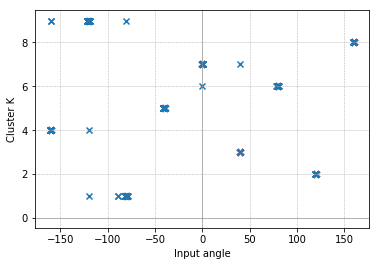

In [12]:
fig, ax = plt.subplots()
ax.scatter(data.A, K_list+1, marker='x')
ax.grid(True, which='both', linewidth=0.5, linestyle='--')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_ylabel('Cluster K')
ax.set_xlabel('Input angle')
plt.show()

Da die Korrelation bis auf eine geringe Zahl an Ausreißern recht eindeutig ist, wird für jedes Cluster eine Wahrscheinlichkeitsverteilung (PDF) aufgestellt: $p(s=k | α)$. Dies bezeichnet die bedingte Wahrscheinlichkeit für die Zugehörigkeit eines Punkts zum Cluster $k$ bei gegebenem Aufnahmewinkel $α$. Dazu wird eine Funktion definiert, die Mittelwert und Varianz der Punkte berechnet. Damit kann die PDF als Gaußverteilung aufgestellt werden.


In [13]:
def calc_gaussians(clusters, K):
    
    # Use Gaussians to estimate the PDFs of a point belonging to the k-th cluster
    means, variances = [], []
    for j in range(0, K):
        a = []
        for i in range(0, len(clusters[j])):
            a.append(clusters[j][i][2])
        means.append(np.mean(np.asarray(a)).round(2))
        variances.append(np.var(np.asarray(a)).round(2))
        
    return means, variances

In [14]:
means, variances = calc_gaussians(clusters, 9)

Nun werden alle Punkte mithilfe dieser PDFs klassifiziert, d.h. einem Cluster zugeordnet.

In [15]:
def gauss_class(input_angles, means, variances, K):
   
    class_result = []
    
    for i in range(0, len(input_angles)):
        cluster_pdfs = []
        for j in range(0, K):
            cluster_pdfs.append(1 / np.sqrt(2 * np.pi) / variances[j] * np.exp(- np.square(input_angles[i]-means[j])) / np.square(variances[j]))
        class_result.append(np.argmax(cluster_pdfs))
    
    return class_result


In [16]:
c_list = gauss_class(data.A, means, variances, 9)

Mit dem berechneten Gauß-Klassifikator lässt sich nun das Klassifikationsergebnis generalisieren:

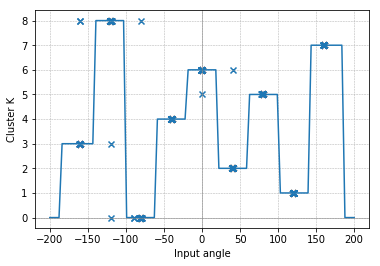

In [17]:
x_axis = np.linspace(-200, 200, 100)
y_axis = gauss_class(x_axis, means, variances, 9)

fig, ax = plt.subplots()
ax.scatter(data.A, K_list, marker='x')
ax.plot(x_axis, y_axis)
ax.grid(True, which='both', linewidth=0.5, linestyle='--')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_ylabel('Cluster K')
ax.set_xlabel('Input angle')
plt.show()

Nun ist das Modell für den Ablagefehler vollständig. 
Die Orientierung des Ablagefehlers korrelliert mit dem Aufnahmewinkel, wie eine Untersuchung zeigt:

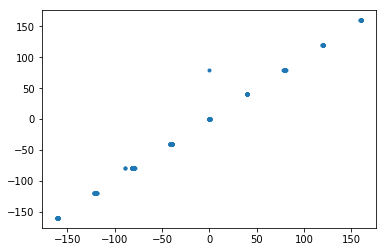

In [18]:
plt.scatter(data.A, data.dA, marker='.')
plt.show()

# Performance-Analyse

Nun wird das mathematische Modell für die Positionsschätzung anhand der wahren Daten evaluiert. Ziel ist es, den Schätzfehler des Modells zu berechnen. Dazu wird wieder das berechnete Modell aufgestellt und in eine Funktion zur Schätzung des Modellfehlers integriert.


In [33]:
def calc_model_error(dataset):
    
    outputs = calc_outputs_list(data)
    clusters, K_list  = find_clusters(data, outputs)
    linear_model = calc_model_parameters(data, clusters, 9)
    means, variances = calc_gaussians(clusters, 9)
    cluster_list = gauss_class(dataset.A, means, variances, 9)
    [x0, y0, ai, bi, A, B] = linear_model
    abs_err = []

    for i in range(0, dataset.number_of_points):
        k = cluster_list[i]
        x_est = x0[k] + dataset.X[i]*(ai[k]/A)
        y_est = y0[k] + bi[k] - dataset.Y[i]*(bi[k]/B)
        x_real, y_real = dataset.dX[i], dataset.dY[i]
        abs_err.append(np.sqrt(np.square(x_est - x_real) + np.square((y_est - y_real))))
        mae = np.mean(np.asarray(abs_err)).round(2)
        
    return abs_err


In [34]:
def plot_position_error(dataset, error, title):
    
    abs_err = error

    plt.plot(abs_err)
    plt.title(title)
    plt.grid(True, which='both', linewidth=0.5, linestyle='--')
    axes = plt.gca()
    axes.set_ylim([-1, 27])
    fig = plt.gcf()
    fig.set_size_inches(12, 2.5, forward=True)
    plt.show()
    return

In [65]:
def calc_error_measures(dataset):
    
    abs_err = calc_model_error(dataset)
    mae = np.mean(np.asarray(abs_err)).round(2)
    var = np.var(np.asarray(abs_err)).round(2)
    max_err = np.max(abs_err).round(2)
    
    return [mae, max_err, var]

Jetzt kann der Schätzfehler des Modells für die Test- und Trainingsdaten bestimmt werden. Die Modellberechnung ist bereits in der Funktion calc_model_error integriert. Die Funktion calc_error_measures implementiert die statistischen Qualitätsmaße, sodass sich zu jedem Datensatz der Mittelwert, die Varianz und der maximale Fehler berechnen lässt.

Row skipped


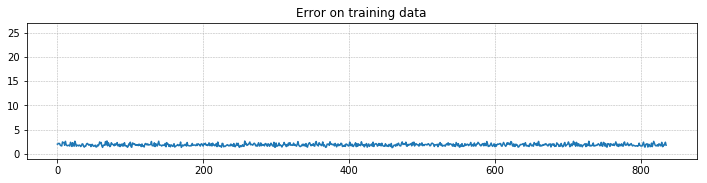

In [67]:
data = Dataset()
data.read_data('dataset/data_1_training.csv', 2)
error = calc_model_error(data)
plot_position_error(data, error, 'Error on training data')

In [68]:
[mae, max_err, var] = calc_error_measures(data)
print("Fehler Trainingsdaten:")
print("mae = " + str(mae))
print("max = " + str(max_err))
print("var = " + str(var))

Fehler Trainingsdaten:
mae = 1.88
max = 2.68
var = 0.07


Row skipped


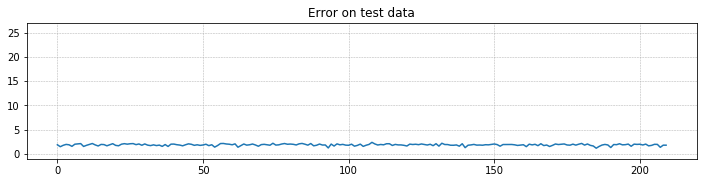

In [69]:
data = Dataset()
data.read_data('dataset/data_1_test.csv', 2)
error = calc_model_error(data)
plot_position_error(data, error, 'Error on test data')

In [70]:
[mae, max_err, var] = calc_error_measures(data)
print("Fehler Testdaten:")
print("mae = " + str(mae))
print("max = " + str(max_err))
print("var = " + str(var))

Fehler Testdaten:
mae = 1.88
max = 2.39
var = 0.04


Row skipped


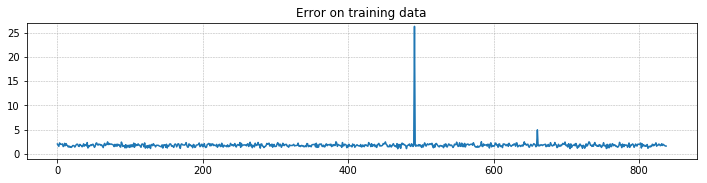

In [71]:
data = Dataset()
data.read_data('dataset/data_2_training.csv', 2)
error = calc_model_error(data)
plot_position_error(data, error, 'Error on training data')

In [72]:
[mae, max_err, var] = calc_error_measures(data)
print("Fehler Trainingsdaten:")
print("mae = " + str(mae))
print("max = " + str(max_err))
print("var = " + str(var))

Fehler Trainingsdaten:
mae = 1.81
max = 26.29
var = 0.8


Row skipped


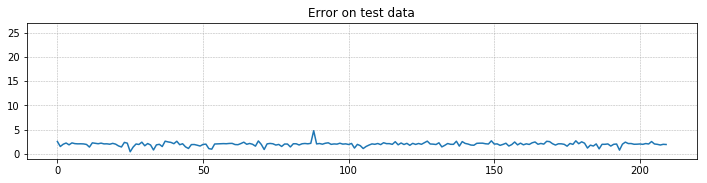

In [73]:
data = Dataset()
data.read_data('dataset/data_2_test.csv', 2)
error = calc_model_error(data)
plot_position_error(data, error, 'Error on test data')

In [74]:
[mae, max_err, var] = calc_error_measures(data)
print("Fehler Trainingsdaten:")
print("mae = " + str(mae))
print("max = " + str(max_err))
print("var = " + str(var))

Fehler Trainingsdaten:
mae = 2.01
max = 4.79
var = 0.16
